<a href="https://colab.research.google.com/github/faremi/Banking/blob/master/number%2083.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)


fastai version : 1.0.61
transformers version : 2.11.0


In [3]:
train_set = pd.read_csv("/content/drive/My Drive/Zindi/Train.csv")
test_set = pd.read_csv("/content/drive/My Drive/Zindi/Test.csv")

In [4]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
    
model_type = 'roberta'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [5]:
def to_sentiment(rating):
  if rating == "Depression":
    return 0
  elif rating == "Drugs":
    return 1
  elif rating == "Suicide":
    return 2
  elif rating == "Alcohol":
    return 3
  else: 
    return 5

In [6]:
train_set['sentiment'] = train_set.label.apply(to_sentiment)
class_names = ['Depression', 'Drugs', 'Suicide','Alcohol']

In [7]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
import string
import nltk
train_set['text'] = train_set['text'].apply(lambda x:clean_text(x))
from textblob import TextBlob
train_set['text'].apply(lambda x: str(TextBlob(x).correct()))
from textblob import Word
nltk.download('wordnet')
train_set['text'] = train_set['text'].apply(lambda x: " ".join([Word(word).
lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
train_set.head()

,ID,text,label,sentiment
0,SUAVK39Z,i feel that it wa better i dieam happy,Depression,0
1,9JDAGUV3,why do i get hallucination,Drugs,1
2,419WR1LQ,i am stresseed due to lack of financial suppor...,Depression,0
3,6UY7DX6Q,why is life important,Suicide,2
4,FYC0FTFB,how could i be helped to go through the depres...,Depression,0


In [10]:
model_name = 'distilroberta-base'
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
        
transformer_tokenizer = tokenizer_class.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [11]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [12]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [13]:
seed = 42
use_fp16 = False
bs = 16

In [14]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [15]:
seed_all(seed)

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [18]:
databunch = (TextList.from_df(train_set, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'sentiment')
             .add_test(test_set)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [19]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [20]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġi Ġam Ġfinancially Ġconstrained Ġover Ġschool Ġfee Ġand Ġmy Ġfamily Ġbackground Ġis Ġnot Ġstable Ġwith Ġa Ġlot Ġof Ġdebts âĢ¦ i Ġhave Ġan Ġelderly Ġbrother Ġwho Ġcould Ġeasily Ġsupport Ġme Ġbut Ġha Ġno Ġjob Ġeven Ġafter Ġgraduating </s>,0
<s> Ġi Ġam Ġfacing Ġa Ġlot Ġof Ġchallenge Ġin Ġlife Ġfinancially Ġemotionally Ġpsy c ologically Ġand Ġwith Ġno Ġsolutions âĢ¦ how Ġcan Ġi Ġsafely Ġlook Ġfor Ġsolution Ġabout Ġdepression Ġon Ġgoogle </s>,0
<s> Ġi Ġfeel Ġlike Ġthe Ġworld Ġwa Ġagainst Ġme Ġespecially Ġfrom Ġfriend Ġand Ġrelative Ġwho Ġwere Ġclose Ġto Ġme Ġi Ġconqu red Ġit Ġthat Ġmy Ġlife Ġis Ġmore Ġimportant </s>,0
<s> Ġwhat Ġcan Ġi Ġdo Ġto Ġavoid Ġloss Ġof Ġconcentration Ġin Ġclass Ġthrough Ġfantas izing Ġin Ġclass Ġand Ġstudy Ġtimes on Ġromance Ġand Ġp on ographic Ġissue </s>,0
<s> Ġi Ġfeel Ġdepressed Ġbecause Ġof Ġissue Ġwith Ġmy Ġbest Ġfriend Ġand Ġmy Ġparent Ġi Ġwa Ġat Ġmy Ġlowest Ġpoint Ġbeing Ġlow key Ġeveryday </s>,0


In [21]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 39])
tensor([[    0,   939,   524, 10625, 26525,    81,   334,  4029,     8,   127,
           284,  3618,    16,    45,  4375,    19,    10,   319,     9, 13035,
          1174,   118,    33,    41,  7497,  2138,    54,   115,  2773,   323,
           162,    53,  2489,   117,   633,   190,    71, 15128,     2],
        [    0,   939,   524,  2114,    10,   319,     9,  1539,    11,   301,
         10625, 13582, 43114,   438, 30570,     8,    19,   117,  2643,  1174,
          9178,    64,   939,  7385,   356,    13,  2472,    59,  6943,    15,
         39121,     2,     1,     1,     1,     1,     1,     1,     1],
        [    0,   939,   619,   101,     5,   232, 13332,   136,   162,   941,
            31,  1441,     8,  5407,    54,    58,   593,     7,   162,   939,
         40647,  2050,    24,    14,   127,   301,    16,    55,   505,     2,
             1,     1,     1,     1,     1,     1,     1,     1,    

In [22]:
config = config_class.from_pretrained(model_name)
config.num_labels = 4

transformer_model = model_class.from_pretrained(model_name, config = config)
# transformer_model = model_class.from_pretrained(model_name, num_labels = 5)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [23]:
pretrained_model_name = 'distilroberta-base'
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [24]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [25]:
print(learner.model)


CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [26]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.pooler]


In [27]:


learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)



Learner split in 8 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2):

In [28]:
learner.save('untrain')

In [29]:
seed_all(seed)
learner.load('untrain');

In [30]:
learner.freeze_to(-1)

In [31]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [39, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [39, 768]            394,752    False     
______________________________________________________________________
Embedding            [39, 768]            768        False     
______________________________________________________________________
LayerNorm            [39, 768]            1,536      False     
______________________________________________________________________
Dropout              [39, 768]            0          False     
______________________________________________________________________
Linear               [39, 768]            590,592    False     
______________________________________________________________________
Linear               [39, 768]            590,592    False     
_______________________________________

In [32]:

learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-04
Min loss divided by 10: 1.74E-04


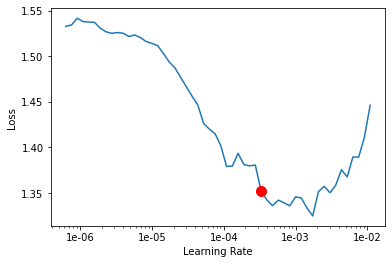

In [33]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.011560,1.064681,0.606557,0.393443,00:00


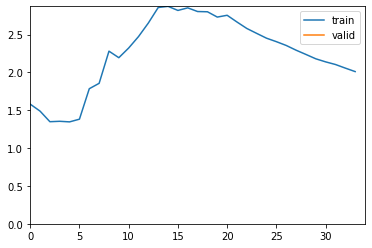

In [34]:


learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))



In [35]:


learner.save('first_cycle')



In [36]:


seed_all(seed)
learner.load('first_cycle');



In [37]:
learner.freeze_to(-2)

In [38]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.824612,0.859796,0.639344,0.360656,00:01


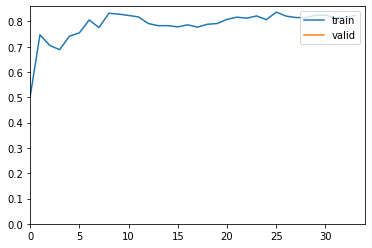

In [39]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [40]:
learner.save('second_cycle')

In [41]:
seed_all(seed)
learner.load('second_cycle');

In [42]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.559259,0.612344,0.721311,0.278689,00:01


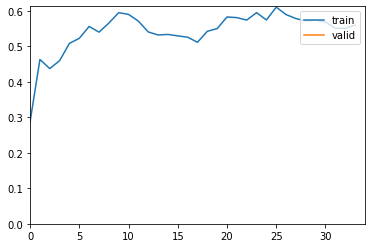

In [43]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [44]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.490695,0.450145,0.803279,0.196721,00:03
1,0.338456,0.361543,0.754098,0.245902,00:03


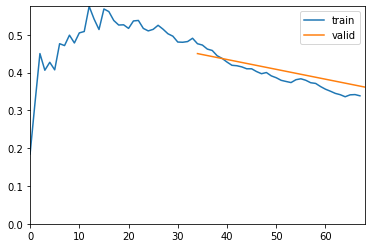

In [45]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [46]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values# For Valid

preds, pred_values = get_preds_as_nparray(DatasetType.Test)

In [47]:
sub=pd.read_csv('/content/drive/My Drive/Zindi/SampleSubmission.csv')
sub.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0


In [48]:
sub['Depression']=preds[:,0]
sub['Alcohol']=preds[:,3]
sub['Suicide']=preds[:,2]
sub['Drugs']=preds[:,1]

In [49]:
sub.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0.585651,0.110313,0.262405,0.041631
1,03BMGTOK,0.881384,0.031131,0.075187,0.012298
2,03LZVFM6,0.998722,0.000097,0.001163,0.000017
3,0EPULUM5,0.988065,0.001282,0.010305,0.000348
4,0GM4C5GD,0.001222,0.413222,0.016447,0.569109


In [52]:
sub.to_csv('resultssfile22.csv',index=False)

In [51]:
test_set.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
